# Projeto 3 de Ciência dos Dados

Integrantes:

Ana Clara
João Pedro Varella
João Guilherme

## Imports

In [73]:
import pandas as pd
import ast
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
import numpy as np
from sklearn.datasets import load_digits
digits = load_digits()

___

## Contextualização

### Pergunta:

A pergunta principal que será respondida no projeto é como diversos fatores influenciam na bilheteria de um filme. Como forma de estudo, estipularemos uma meta de bilheteria no decorrer das análises.

Sabe-se que anualmente, centenas de filmes entram em cartaz pelos diversos países do mundo. Dentre eles, a grande maioria não atinge altos valores de bilheteria. Por meio desse estudo, será possível compreender o que majoritariamente influencia se um filme será um sucesso ou se será um fracasso de bilheteria com as análises das diversas variáveis do Dataset. Essas questões serão abordadas no andamento do projeto, para que, no fim, possamos responder à pergunta inicial.

### Sobre o Dataset:

O Dataset utilizado, entitulado "The Movies Dataset", extraído do Kaggle, reúne diversas informações sobre mais de 45 mil filmes. Dentre essas, pode-se citar: atores, diretores, produtores, orçamento, bilheteria, gênero, popularidade, faixa etária, etc. 

No entanto, filtrou-se algumas variáveis julgadas como mais relevantes para o intuito do estudo. Dessa forma, certas categorias foram dispensadas para o andamento das análises.

O Dataset escolhido está disponível no link abaixo:

https://www.kaggle.com/rounakbanik/the-movies-dataset

### Método utilizado:

Para a realização do projeto utilizaremos do método de classificação do Random Forest. Afinal, o modelo se utilizará das variáveis de entrada do nosso Dataset, devolvendo, ao fim, uma variável de saída binária (no caso do nosso projeto, se o filme atinge ou não a meta estipulada). A forma pela qual esse método realiza essa análise é: Inicialmente, recebe um filme qualquer e verifica se o dado filme possui uma primeira variável de entrada (Tomemos a presença do ator Tom Hanks como exemplo) e em seguida, checa alguma outra variável de entrada (filme ser ou não de ação) e assim por diante, de forma que cada "árvore" devolverá uma variável binária para o filme atingir a meta, baseado nas respostas das variáveis de entrada. Ao fim da análise de todas as árvores, o Random Forest devolve uma variável de saída também na forma binária, se o filme conseguirá ou não bater a marca estabelecida, baseado nas respostas finais de cada árvore.

##

## Lendo arquivos

In [2]:
df = pd.read_csv("movies_metadata.csv")
df2 = pd.read_csv("credits.csv")

C:\Users\ana clara\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Limpeza do DataFrame "Meta Data"

### Retirada dos JSONs

No dataset utilizado, algumas variáveis estavam codificadas na forma de JSON. Para acessá-las, foi necessário extrair as informações e transformá-las em um dicionário. Nesta etapa da análise, extraímos os nomes dos atores de cada um dos filmes. Dessa forma, foi possível criar um dicionário relacionando duas variáveis, em que a chave corresponde ao nome do ator, e o valor dessa chave é o número de filmes em que cada ator atuou.

In [3]:
from collections import defaultdict
atores = defaultdict(int)
for e in df2.index:
    data_dict = ast.literal_eval(df2["cast"][e])
    for palavras in data_dict:
        nome = palavras['name']
        
        atores[nome] += 1

### Código para limpeza de certas variáveis tais como: revenue, budget, produtora e gênero:

In [4]:
df_0 = df[df['revenue'] > 0]
df_budget = df_0[df_0['budget'] != '0']
df_clean = df_budget[df_budget['production_companies'] != '[]']
df_super_clean = df_clean[df_clean['genres'] != '[]']

In [5]:
df_mega_clean = df_super_clean[["id","genres","budget","revenue","production_companies"]]
df_mega_clean['budget'] = df_mega_clean['budget'].astype(float)
df_mega_clean.head()

C:\Users\ana clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,id,genres,budget,revenue,production_companies
0,862,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",30000000.0,373554033.0,"[{'name': 'Pixar Animation Studios', 'id': 3}]"
1,8844,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",65000000.0,262797249.0,"[{'name': 'TriStar Pictures', 'id': 559}, {'na..."
3,31357,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",16000000.0,81452156.0,[{'name': 'Twentieth Century Fox Film Corporat...
5,949,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",60000000.0,187436818.0,"[{'name': 'Regency Enterprises', 'id': 508}, {..."
8,9091,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",35000000.0,64350171.0,"[{'name': 'Universal Pictures', 'id': 33}, {'n..."


## Análise Exploratória

Primeiramente foram analisadas as variáveis mais simplórias do DataFrame. Dessa forma, foram plotados histogramas que relacionam a frequência absoluta das variáveis Budget e Revenue.

### Histograma da variável budget

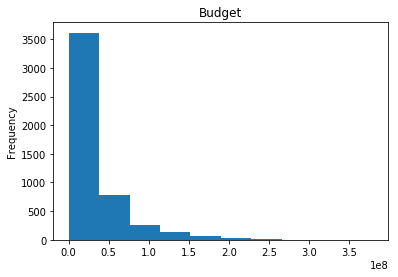

In [74]:
df_mega_clean.budget.plot.hist(density = False)
plt.title('Budget')
plt.show()

### Histograma da variável revenue

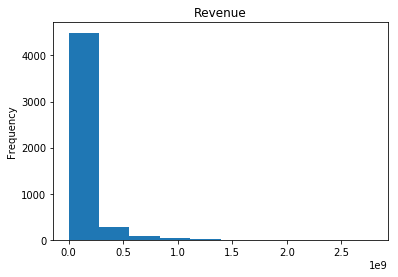

In [75]:
df_mega_clean.revenue.plot.hist(density = False)
plt.title('Revenue')
plt.show()

Neste gráfico de dispersão, foram relacionadas as duas variáveis acima, de modo que fosse possível constatar a relação entre filmes com alto orçamento e filmes com alta bilheteria.

### Gráfico de dispersão das variáveis budget e revenue

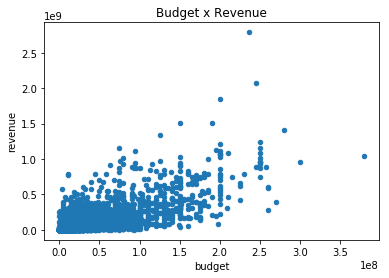

In [76]:
df_mega_clean.plot.scatter(x="budget", y = "revenue")
plt.title('Budget x Revenue')
plt.show()

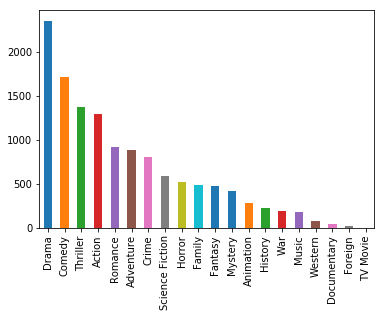

In [77]:
generos = []
for e in df_mega_clean.index:
    data_dict = ast.literal_eval(df_mega_clean["genres"][e])
    for palavras in data_dict:
        generos.append(palavras['name'])

df_generos = pd.DataFrame(generos)
df_generos
geneross = df_generos[0].value_counts()
geneross
geneross.plot(kind='bar')

In [13]:
revenues_por_categoria = {}
categorias = [
    'Drama', 'Comedy', 'Thriller',
    'Action','Romance','Adventure','Crime','Science Fiction',
    'Horror','Family','Fantasy','Mystery','Animation','History',
    "War",'Music','Western','Documentary','Foreign','TV Movie'
]

for c in categorias:
    revenues_por_categoria[c] = []

for e in df_mega_clean.index:
    data_dict = ast.literal_eval(df_mega_clean["genres"][e])
    for palavras in data_dict:
        cat = palavras["name"]
        #print(cat)
        if cat in revenues_por_categoria:
            revenues_por_categoria[cat].append(df_mega_clean['revenue'][e])
            
for k in revenues_por_categoria:
    revenues_por_categoria[k] = (np.array(revenues_por_categoria[k]))

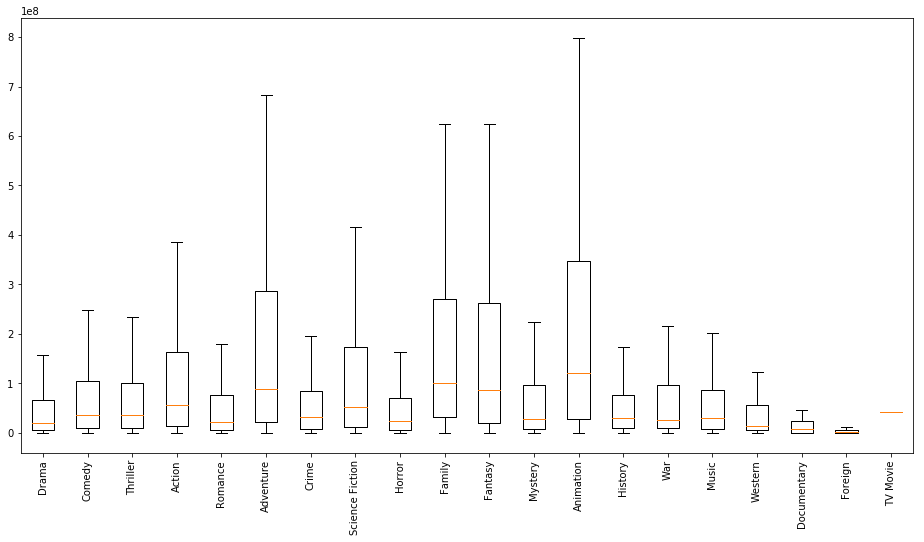

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.boxplot(revenues_por_categoria.values(), showfliers=False)
ax.set_xticklabels(revenues_por_categoria.keys(), rotation='vertical');
#plt.yscale('log')
plt.show()

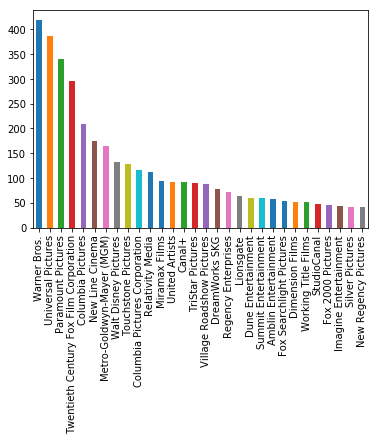

In [15]:
produtoras = []
for e in df_mega_clean.index:
    data_dict = ast.literal_eval(df_mega_clean["production_companies"][e])
   # print(data_dict)
    for palavras in data_dict:
        produtoras.append(palavras['name'])

df_produtoras = pd.DataFrame(produtoras)
df_produtoras
produtorass = df_produtoras[0].value_counts().head(30)
produtorass
produtorass.plot(kind='bar')

In [16]:
revenues_por_produtora = {}
produtoras = [
    'Warner Bros.','Universal Pictures','Paramount Pictures','Twentieth Century Fox Film Corporation','Columbia Pictures',
    'New Line Cinema','Metro-Goldwyn-Mayer (MGM)','Touchstone Pictures','Walt Disney Pictures','Columbia Pictures Corporation',
    'Relativity Media','United Artists','Miramax Films','TriStar Pictures','Canal+','Village Roadshow Pictures','DreamWorks SKG',
    'Regency Enterprises','Lionsgate','Amblin Entertainment','Summit Entertainment','Dune Entertainment','Fox Searchlight Pictures',
    'Dimension Films','Working Title Films','Fox 2000 Pictures','StudioCanal','Silver Pictures','Hollywood Pictures',
    'The Weinstein Company'
]

for p in produtoras:
    revenues_por_produtora[p] = []

for f in df_mega_clean.index:
    data_dict = ast.literal_eval(df_mega_clean["production_companies"][f])
    #print(data_dict)
    for palavras in data_dict:
        #print(palavras)
        prod = palavras["name"]
        if prod in revenues_por_produtora:
            revenues_por_produtora[prod].append(df_mega_clean['revenue'][f])
        
            
#revenues_por_produtora
            
for k in revenues_por_produtora:
    revenues_por_produtora[k] = (np.array(revenues_por_produtora[k]))

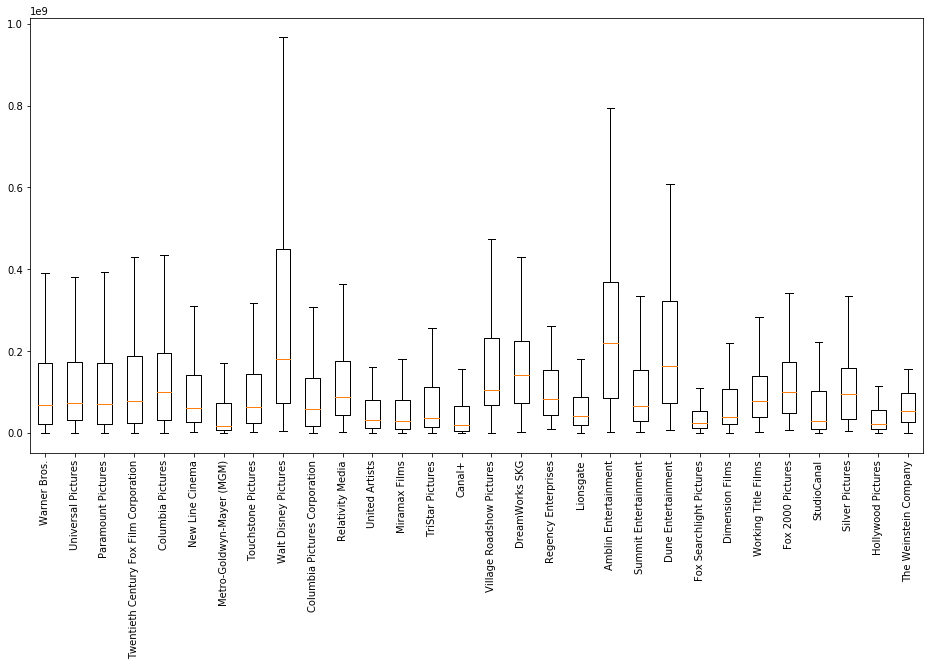

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.boxplot(revenues_por_produtora.values(), showfliers=False)
ax.set_xticklabels(revenues_por_produtora.keys(), rotation='vertical');
#plt.yscale('log')
plt.show()

## Limpeza do DataFrame "Credits"

In [18]:
ser_atores = pd.Series(atores)
ser_atores.head()

Tom Hanks        72
Tim Allen        29
Don Rickles      29
Jim Varney       20
Wallace Shawn    75
dtype: int64

Para visualizar de maneira mais ordenada e clara os dados do DataFrame, selecionamos a parcela de 0.1% de atores com mais produções no cinema. Dessa forma, atingimos todos com mais de 28 aparições:

In [19]:
ser_atores = ser_atores[ser_atores > 28].sort_values(ascending=False)

Para utilizar os dados do DataFrame acima no método do Random Forrest, foi necessário transformar as informações nele em um outro DataFrame com solução binária.

Nesta nova tabela, cada linha representa cada um dos filmes contidos no database, e cada coluna representa os atores selecionados previamente:

In [20]:
df_filmes_atores = pd.DataFrame(index=df2.index, columns=ser_atores.index, dtype=np.uint8)
for e in df2.index:
    data_dict = ast.literal_eval(df2["cast"][e])
    for palavras in data_dict:
        nome = palavras['name']
        if nome in df_filmes_atores.columns:
            df_filmes_atores[nome][e] = 1

In [21]:
df_filmes_atores[df_filmes_atores != 1] = 0
df_filmes_atores.head()

,Bess Flowers,Christopher Lee,John Wayne,Samuel L. Jackson,Gérard Depardieu,Michael Caine,John Carradine,Donald Sutherland,Jackie Chan,Frank Welker,...,Syd Saylor,George Raft,Quentin Tarantino,Paul Winfield,Emilio Estevez,Chow Yun-fat,Chazz Palminteri,Carmen Electra,Olaf Hytten,Walter Gotell
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Nota-se que neste DataFrame, a grande maioria dos dígitos é 0, o que representa o óbvio, os atores apareceram em poucos filmes em relação ao total estudado

In [22]:
df.drop_duplicates(subset ="original_title", 
                     keep = 'first', inplace = True) 
df["original_title"].value_counts().value_counts()

1    43373
Name: original_title, dtype: int64

In [23]:
df['bilhao'] = df.revenue > 1e9

## Limpeza das variáveis de entrada tais como: revenue, budget, produtora e gênero:

In [24]:
df_0 = df[df['revenue'] > 0]
df_budget = df_0[df_0['budget'] != '0']
df_clean = df_budget[df_budget['production_companies'] != '[]']
df_super_clean = df_clean[df_clean['genres'] != '[]']

In [25]:
df_mega_clean = df_super_clean[["id","genres","budget","revenue","production_companies"]]
df_mega_clean['budget'] = df_mega_clean['budget'].astype(float)

C:\Users\ana clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
df_mega_clean.revenue.quantile(0.8)

129924654.00000012

Na célula acima, verificou-se que o valor que corta os 20% das maiores bilheterias é 129 milhões de dólares, dessa forma, definimos que o valor que seria usado no modelo como meta de bilheteria para os filmes seria 150 milhões de dólares

In [27]:
milhao = []
for dinheiro in df_mega_clean.revenue:
    if dinheiro > 1.5e8:
        milhao.append(1)
    else:
        milhao.append(0)

Após definir a meta do modelo, percorremos todos os filmes e adicionamos uma nova coluna ao nosso dataframe original que indica se cada filme atingiu ou não atingiu os 150 milhões de dólares

In [28]:
df_mega_clean['Fez ou não 150 mi'] = milhao
df_mega_clean.head()

C:\Users\ana clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,id,genres,budget,revenue,production_companies,Fez ou não 150 mi
0,862,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",30000000.0,373554033.0,"[{'name': 'Pixar Animation Studios', 'id': 3}]",1
1,8844,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",65000000.0,262797249.0,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",1
3,31357,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",16000000.0,81452156.0,[{'name': 'Twentieth Century Fox Film Corporat...,0
5,949,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",60000000.0,187436818.0,"[{'name': 'Regency Enterprises', 'id': 508}, {...",1
8,9091,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",35000000.0,64350171.0,"[{'name': 'Universal Pictures', 'id': 33}, {'n...",0


### Filtrando os atores por meio da limpeza estabelecida no DataFrame "MetaData"

In [29]:
lista_teste = []
for numero in df_filmes_atores.index:
    if numero not in df_mega_clean.id:
        lista_teste.append(numero)
        
atores_certos = df_filmes_atores.drop(lista_teste, axis=0)

No dataframe acima, foi selecionado os atores que participam dos filmes filtrados no Dataframe "mega_clean" fazendo com que agora podemos observar quais atores participaram dos filmes relevantes 

In [30]:
atores_certos['Fez ou não 150 mi'] = milhao
atores_certos.head()

,Bess Flowers,Christopher Lee,John Wayne,Samuel L. Jackson,Gérard Depardieu,Michael Caine,John Carradine,Donald Sutherland,Jackie Chan,Frank Welker,...,George Raft,Quentin Tarantino,Paul Winfield,Emilio Estevez,Chow Yun-fat,Chazz Palminteri,Carmen Electra,Olaf Hytten,Walter Gotell,Fez ou não 150 mi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [31]:
sim_ou_nao = atores_certos['Fez ou não 150 mi']
y = df_mega_clean['Fez ou não 150 mi']

# Randon Forest 

O próximo passo será nós rodarmos o Randon Forest com o nossos Datframes "binários" para que agora possamos verificar nosso objetivo que é verificar se de fato os feature que nós escolhemos impactam na bilheteria

## Influência dos atores na bilheteria

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(atores_certos.drop(['Fez ou não 150 mi'],axis='columns'),sim_ou_nao,test_size = 0.3)

In [33]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 40)
model.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
model.score(X_test,Y_test)

0.8097826086956522

A partir desse resultado é possível perceber que os atores não influenciam para que um filme passe ou não da marca de 150 milhoes de bilheteria, já que a nossa acurácia deu menos que 80%, ou seja, menor ainda que nosso corte das maiores bilheterias, portanto nosso classificador pode está estimando que todos os filmes nunca atinjam a marca estabelecida por nós e quase sempre o classificador acerta, só 20% das vezes não, porque 20% dos filmes realmente conseguem atingir essa marca

## Influência das categorias na bilheteria

In [35]:
categorias2 = defaultdict(int)
for e in df_mega_clean.index:
    data_dict = ast.literal_eval(df_mega_clean["genres"][e])
    for palavras in data_dict:
        tipo = palavras['name']
        categorias2[tipo] += 1

In [36]:
ser_categorias = pd.Series(categorias2)

In [37]:
df_filmes_categorias = pd.DataFrame(index=df_mega_clean.index, columns=ser_categorias.index, dtype=np.uint8)
for e in df_mega_clean.index:
    data_dict = ast.literal_eval(df_mega_clean["genres"][e])
    #print(data_dict)
    for palavras in data_dict:
        tipo = palavras['name']
        #print(tipo)
        if tipo in df_filmes_categorias.columns:
             df_filmes_categorias[tipo][e] = 1


In [38]:
df_filmes_categorias[df_filmes_categorias != 1] = 0
df_filmes_categorias.head()

,Animation,Comedy,Family,Adventure,Fantasy,Drama,Romance,Action,Crime,Thriller,History,Science Fiction,Mystery,Horror,War,Foreign,Documentary,Western,Music,TV Movie
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(df_filmes_categorias,sim_ou_nao,test_size = 0.3)

model = RandomForestClassifier(n_estimators = 40)
model.fit(X2_train,Y2_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [40]:
model.score(X2_test,Y2_test)

0.8410326086956522

## Influência das produtoras na bilheteria

In [41]:
prod2 = defaultdict(int)
for e in df_mega_clean.index:
    data_dict = ast.literal_eval(df_mega_clean['production_companies'][e])
    for palavras in data_dict:
        produ = palavras['name']
        prod2[produ] += 1

In [42]:
ser_produtora = pd.Series(prod2)

In [43]:
df_filmes_produtoras = pd.DataFrame(index=df_mega_clean.index, columns=ser_produtora.index, dtype=np.uint8)
for e in df_mega_clean.index:
    data_dict = ast.literal_eval(df_mega_clean["production_companies"][e])
    #print(data_dict)
    for palavras in data_dict:
        produ = palavras['name']
        #print(tipo)
        if produ in df_filmes_produtoras.columns:
             df_filmes_produtoras[produ][e] = 1


In [44]:
df_filmes_produtoras[df_filmes_produtoras != 1] = 0
df_filmes_produtoras.head()

,Pixar Animation Studios,TriStar Pictures,Teitler Film,Interscope Communications,Twentieth Century Fox Film Corporation,Regency Enterprises,Forward Pass,Warner Bros.,Universal Pictures,Imperial Entertainment,...,Rumble Entertainment,Hollywood Storm,Czar Pictures,S Pictures,Corner Work,Closed on Mondays Entertainment,Star Thrower Entertainment,Acacia Filmed Entertainment,Кинокомпания «Lunapark»,Инвада фильм
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
X3_train, X3_test, Y3_train, Y3_test = train_test_split(df_filmes_produtoras,sim_ou_nao,test_size = 0.3)

model = RandomForestClassifier(n_estimators = 40)
model.fit(X3_train,Y3_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [46]:
model.score(X3_test,Y3_test)

0.8559782608695652

## Random Forest com todas as features

In [63]:
df_forest = pd.concat([
    df_filmes_categorias,
    atores_certos.drop(['Fez ou não 150 mi'],axis='columns'),
    df_filmes_produtoras,
    df_mega_clean.budget,

], axis=1)

In [64]:
X4_train, X4_test, Y4_train, Y4_test = train_test_split(df_forest,sim_ou_nao,test_size = 0.3)

model = RandomForestClassifier(n_estimators = 60)
model.fit(X4_train,Y4_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [65]:
model.score(X4_test,Y4_test)

0.8743206521739131

In [66]:
sorted(list(zip(model.feature_importances_, X4_test.columns)), reverse=True)

[(0.12573123755944637, 'budget'),
 (0.015130078266124981, 'Adventure'),
 (0.009420883019891683, 'Animation'),
 (0.009396114277484918, 'Drama'),
 (0.007364309928414228, 'Action'),
 (0.006808801199394255, 'Comedy'),
 (0.006627907485789485, 'Family'),
 (0.005743257777899937, 'Fantasy'),
 (0.005570760454070025, 'Walt Disney Pictures'),
 (0.0053464974662359764, 'DreamWorks Animation'),
 (0.004550559016239674, 'Thriller'),
 (0.004399898744122421, 'Marvel Studios'),
 (0.004272099280299022, 'TSG Entertainment'),
 (0.004200265423955239, 'Science Fiction'),
 (0.00415857097597067, 'Romance'),
 (0.004028174140799714, 'John Ratzenberger'),
 (0.003954433324067333, 'Universal Pictures'),
 (0.003920592806723576, 'Tom Cruise'),
 (0.003854320400446638, 'Amblin Entertainment'),
 (0.0036060403359878205, 'Warner Bros.'),
 (0.0035379564378462455, 'Sunswept Entertainment'),
 (0.0035212750027112443, 'Jerry Bruckheimer Films'),
 (0.0034322054123229434, 'Twentieth Century Fox Film Corporation'),
 (0.00333292582

In [67]:
model.feature_importances_

array([9.42088302e-03, 6.80880120e-03, 6.62790749e-03, ...,
       4.21979563e-09, 0.00000000e+00, 1.25731238e-01])

# Modelos utilizados para comparação

## Regressão Logística com todas as features

In [62]:
model = LogisticRegression()
model.fit(X4_train,Y4_train)
Ypred = model.predict(X4_test)
print(accuracy_score(Y4_test,Ypred))

C:\Users\ana clara\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8362771739130435


## Máquina de vetores de suporte com todas as features

In [72]:
model = SVC()
model.fit(X4_train,Y4_train)
Ypred = model.predict(X4_test)
print(accuracy_score(Y4_test,Ypred))

C:\Users\ana clara\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8743206521739131
